__Useful Resources:__
- [Geocoding Raster and Vector Data](http://www.guilles.website/2018/06/12/tutorial-exploring-raster-and-vector-geographic-data-with-rasterio-and-geopandas/)
- [Company doing something analagous](https://solargis.com/products/regional-solar-study/)
- [Paper on Impacts of Predictability and Variability in RE Resources](https://www.nrel.gov/docs/fy13osti/58274.pdf)
- [How Energy Grids Work](https://www.eia.gov/energyexplained/index.php?page=electricity_delivery) ([WIKI](https://en.wikipedia.org/wiki/Variable_renewable_energy))
- [Build a Predictive Model in 10min](https://www.analyticsvidhya.com/blog/2015/09/build-predictive-model-10-minutes-python/)

In [1]:
# There is already something like this out there
# https://www.eia.gov/state/maps.php?v=Electricity
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import requests
import geopandas
import urllib.request
import re
import os

In [44]:
final_cols = ['code','city','state','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

# Sun Data
sun_url = "https://www1.ncdc.noaa.gov/pub/data/ccd-data/pctpos15.dat"
sun_df = pd.read_fwf(sun_url)
sun_df.dropna(inplace=True) # drop rows without data on every month
sun_df[['tmp','state']] = sun_df['Unnamed: 0'].str.split(pat=",",expand=True)
sun_df['code'] = sun_df.apply(lambda row: row.tmp[0:5], axis=1)
sun_df['city'] = sun_df.apply(lambda row: row.tmp[5:], axis=1)
sun_df.drop(columns = ['Unnamed: 0','POR','tmp'],inplace=True)
sun_df = sun_df[sun_df['state'] !='PR']
sun_df = sun_df[final_cols]
for c in sun_df.columns[3:]:
    sun_df[c] = sun_df[c].astype('float64')

# Stack dataframe so sunshine values are all in a single column
sun_df_stacked = pd.DataFrame(columns = ['code','city','state','month','AvgDailySun'])
sun_ids_df = sun_df[['code','city','state']]
months = list(range(1,13))
months = [str(item).zfill(2) for item in months]
m = 0
for c in sun_df.columns[3:]:
    tmp = pd.DataFrame(columns = ['month','AvgDailySun'])
    tmp['AvgDailySun'] = sun_df[c]
    tmp['month'] = months[m]
    m = m+1
    tmp = pd.concat([sun_ids_df,tmp],axis=1)
    sun_df_stacked = pd.concat([sun_df_stacked, tmp],axis = 0)
#print(sun_df_stacked.head(5))
#print("")
#print(sun_df_stacked.dtypes)

# Just look at state-average values for now
# we can look into specific cities later
avg_sun_df = sun_df_stacked.groupby(['state','month'],as_index=False)['AvgDailySun'].mean()
print("SunData")
print(avg_sun_df.head(5))

SunData
  state month  AvgDailySun
0    AK    01    40.000000
1    AK    02    45.666667
2    AK    03    47.666667
3    AK    04    48.000000
4    AK    05    49.000000


In [3]:
subarr = []
print(bool(subarr))

False


In [45]:
# MaxTemperature Data
tmax_url = "https://www1.ncdc.noaa.gov/pub/data/ccd-data/nrmmax.txt"
tmax_df = pd.read_csv(tmax_url,names = ['code','city','tmp','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC','ANN'],skiprows = 1)
tmax_df.dropna(inplace=True) # drop rows without data on every month
tmax_df['state'] = tmax_df.apply(lambda row: row['tmp'][0:3], axis=1)
tmax_df['state'] = tmax_df['state'].str.strip()
tmax_df['city'] = tmax_df['city'].str.strip()
tmax_df['city'] = tmax_df['city'].str.replace(" AP","")
tmax_df['city'] = tmax_df['city'].str.replace(" C.O.","")
tmax_df['YRS'] = tmax_df.apply(lambda row: row.tmp[2:], axis=1)
tmax_df.drop(columns = ['tmp','YRS'],inplace=True)
tmax_df['code'] = tmax_df['code'].astype("str") # month can be str
tmax_df['code'] = tmax_df['code'].str.zfill(5) # pad month with zeros
tmax_df = tmax_df[tmax_df['state'] !='PR']
tmax_df = tmax_df[tmax_df['state'] !='PC']
tmax_df = tmax_df[tmax_df['state'] !='D.']
tmax_df = tmax_df[final_cols]

# Stack dataframe so temperature values are all in a single column
tmax_df_stacked = pd.DataFrame(columns = ['code','city','state','month','MaxTemp'])
tmax_ids_df = tmax_df[['code','city','state']]
months = list(range(1,13))
months = [str(item).zfill(2) for item in months]
m = 0
for c in tmax_df.columns[3:]:
    tmp = pd.DataFrame(columns = ['month','MaxTemp'])
    tmp['MaxTemp'] = tmax_df[c]
    tmp['month'] = months[m]
    m = m+1
    tmp = pd.concat([tmax_ids_df,tmp],axis=1)
    tmax_df_stacked = pd.concat([tmax_df_stacked, tmp],axis = 0)
#print(tmax_df_stacked.head(5))
#print("")
#print(tmax_df_stacked.dtypes)

# Just look at state-average values for now
# we can look into specific cities later
avg_tmax_df = tmax_df_stacked.groupby(['state','month'],as_index=False)['MaxTemp'].mean()
print("MaxTempData")
print(avg_tmax_df.head(5))

MaxTempData
  state month  MaxTemp
0    AK    01   18.320
1    AK    02   22.080
2    AK    03   28.175
3    AK    04   38.825
4    AK    05   50.915


In [46]:
# Wind Data
wind_url = 'https://www1.ncdc.noaa.gov/pub/data/ccd-data/wndspd15.dat'
wind_df = pd.read_fwf(wind_url)
wind_df.dropna(inplace=True) # drop rows without data on every month
wind_df.replace(" ","",regex=True,inplace=True)
wind_df[['tmp','state']] = wind_df['Unnamed: 0'].str.split(pat=",",expand=True)
wind_df['code'] = wind_df.apply(lambda row: row.tmp[0:5], axis=1)
wind_df['city'] = wind_df.apply(lambda row: row.tmp[5:], axis=1)
wind_df.drop(columns = ['Unnamed: 0','YRS','tmp'],inplace=True)
wind_df = wind_df[wind_df['state'] !='PR']
wind_df = wind_df[wind_df['state'] !='PC']
wind_df = wind_df[wind_df['state'] !='DC']
wind_df = wind_df[wind_df['state'] !='']
wind_df = wind_df[final_cols]

# Stack dataframe so wind values are all in a single column
wind_df_stacked = pd.DataFrame(columns = ['code','city','state','month','AvgWindSpeed'])
wind_ids_df = wind_df[['code','city','state']]
months = list(range(1,13))
months = [str(item).zfill(2) for item in months]
m = 0
for c in wind_df.columns[3:]:
    tmp = pd.DataFrame(columns = ['month','AvgWindSpeed'])
    tmp['AvgWindSpeed'] = wind_df[c]
    tmp['month'] = months[m]
    m = m+1
    tmp = pd.concat([wind_ids_df,tmp],axis=1)
    wind_df_stacked = pd.concat([wind_df_stacked, tmp],axis = 0)
#print(wind_df_stacked.head(5))
#print("")
#print(wind_df_stacked.dtypes)

# Just look at state-average values for now
# we can look into specific cities later
avg_wind_df = wind_df_stacked.groupby(['state','month'],as_index=False)['AvgWindSpeed'].mean()
print("AvgWindSpeedData")
print(avg_wind_df.head(5))

AvgWindSpeedData
  state month  AvgWindSpeed
0    AK    01         8.905
1    AK    02         9.070
2    AK    03         8.980
3    AK    04         8.810
4    AK    05         8.695


In [47]:
# Combine sun, temp, wind data
# Make a state-month index that matches between three metric dataframes
avg_sun_df['StateMonth'] = avg_sun_df['state']+avg_sun_df['month']
avg_tmax_df['StateMonth'] = avg_tmax_df['state']+avg_tmax_df['month']
avg_wind_df['StateMonth'] = avg_wind_df['state']+avg_wind_df['month']

# Set index of each to the new "StateMonth" column
avg_sun_df.set_index('StateMonth',inplace=True)
avg_tmax_df.set_index('StateMonth',inplace=True)
avg_wind_df.set_index('StateMonth',inplace=True)

weather_df = pd.concat([avg_sun_df,avg_tmax_df['MaxTemp'],avg_wind_df['AvgWindSpeed']],sort=False,axis = 1)
print("WeatherData")
print(weather_df.head(10))

WeatherData
     state month  AvgDailySun  MaxTemp  AvgWindSpeed
AK01    AK    01    40.000000   18.320         8.905
AK02    AK    02    45.666667   22.080         9.070
AK03    AK    03    47.666667   28.175         8.980
AK04    AK    04    48.000000   38.825         8.810
AK05    AK    05    49.000000   50.915         8.695
AK06    AK    06    42.000000   59.550         8.255
AK07    AK    07    38.333333   62.560         7.780
AK08    AK    08    37.333333   60.250         7.875
AK09    AK    09    35.333333   52.480         8.425
AK10    AK    10    30.666667   38.235         8.685


In [48]:
# Energy Data
stateID = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA",\
           "HI","ID","IL","IN","IA","KS","KY","LA","ME","MD",\
           "MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ",\
           "NM","NY","NC","ND","OH","OK","OR","PA","RI","SC",\
           "SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

#Energy Data Types
etypeID = ["ALL-","COW-","PEL-","NG-","NUC-","HYC-","WND-","WWW-","WAS-","TSN-"]

energy_df = pd.DataFrame(columns = ['seriesID','units','state','date','EnergyGen','EnergyType','StateName'])
for e in etypeID:
    for s in stateID:
        url = "http://api.eia.gov/series/?api_key=eb1984b5e857aa521c0c34345b0170aa&series_id=ELEC.GEN."+e+s+"-99.M"
        #print(url)
        r = requests.get(url)
        if len(r.text)>222:
            r = r.json()
            df1 = pd.DataFrame(r['series'][0])
            df1[['Date','EnergyGeneration']] = pd.DataFrame(df1.data.values.tolist(), index=df1.index)
            df1 = df1.join(pd.DataFrame(df1.name.str.split(':',5).tolist(),columns = ['1','2','3','4','5']))
            df1.drop(columns=['name','f','description','copyright','source','iso3166','start','end','updated','data','1','4','5'],inplace=True)
            df1.replace("USA-","",regex=True,inplace=True)
            df1.replace("thousand megawatthours","GWH",regex=True,inplace=True)
            df1.columns = ['seriesID','units','state','date','EnergyGen','EnergyType','StateName']
            df1['date'] = pd.to_datetime(df1['date'],yearfirst=True,format = '%Y%m')
            energy_df = pd.concat([energy_df, df1])
print("EnergyData")
print(energy_df.head(5))

EnergyData
               seriesID units state       date    EnergyGen   EnergyType  \
0  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-11-01  10788.26989   all fuels    
1  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-10-01  10874.00613   all fuels    
2  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-09-01  12823.09790   all fuels    
3  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-08-01  13987.51427   all fuels    
4  ELEC.GEN.ALL-AL-99.M   GWH    AL 2018-07-01  14504.17413   all fuels    

   StateName  
0   Alabama   
1   Alabama   
2   Alabama   
3   Alabama   
4   Alabama   


In [49]:
# get an average energy profile for recent years (2016+)
energy_df['month'] = energy_df.apply(lambda row: row['date'].month, axis=1)
energy_df['month'] = energy_df['month'].astype("str") # month can be str
energy_df['month'] = energy_df['month'].str.zfill(2) # pad month with zeros
energy_df['year'] = energy_df.apply(lambda row: row['date'].year, axis=1)
energy_df = energy_df.loc[energy_df['year']>=2016,:] # just look at 2017 data for now
avg_energy_df = energy_df.groupby(['seriesID','units','state','month','EnergyType','StateName'],as_index=False)['EnergyGen'].mean()
#print("AveragedEnergyData (2016+)")
#print(avg_energy_df.head(5))

# Strip leading and trailing spaces
avg_energy_df['state'] = avg_energy_df['state'].str.strip()
avg_energy_df['StateName'] = avg_energy_df['StateName'].str.strip()
avg_energy_df['seriesID'] = avg_energy_df['seriesID'].str.strip()
avg_energy_df['units'] = avg_energy_df['units'].str.strip()
avg_energy_df['EnergyType'] = avg_energy_df['EnergyType'].str.strip()


# create unique column to use as index (seriesID, state, StateName)
avg_energy_df['unique'] = avg_energy_df['state']+"-"+avg_energy_df['StateName']+"-"+avg_energy_df['month']
avg_energy_df = avg_energy_df.pivot(index = 'unique',columns = 'EnergyType',values=['EnergyGen','month']) # pivot so that individual parameters are columns
avg_energy_df = pd.DataFrame(avg_energy_df.to_records()) # convert back to pd.DataFrame
#print("Pivoted AveragedEnergyData (2016+)")
#print(avg_energy_df.head(50))

# Fix column names
avg_energy_df['mo']= avg_energy_df["('month', 'all fuels')"] # remake 'year' column
avg_energy_df.drop(list(avg_energy_df.filter(like = 'month')), axis = 1, inplace = True) # remove duplicated 'month' columns
avg_energy_df.columns = [hdr.replace("('EnergyGen', '", "EnergyGen_").replace("')", "") for hdr in avg_energy_df.columns] # fix EnergyGen_ colnames
print("Pivoted Fixed AveragedEnergyData (2016+)")
print(avg_energy_df.head(10))
print(len(avg_energy_df))

Pivoted Fixed AveragedEnergyData (2016+)
         unique EnergyGen_all fuels EnergyGen_all solar EnergyGen_coal  \
0  AK-Alaska-01             623.971         0.000116667        57.4272   
1  AK-Alaska-02             530.785             0.04206        54.7384   
2  AK-Alaska-03             569.288            0.181213        51.9046   
3  AK-Alaska-04             496.512            0.253023        41.1083   
4  AK-Alaska-05             487.001             0.29715        43.6944   
5  AK-Alaska-06              473.15              0.2865         37.434   
6  AK-Alaska-07             532.342            0.292437         47.912   
7  AK-Alaska-08             555.722            0.264457        55.9484   
8  AK-Alaska-09             513.695            0.206813        55.0761   
9  AK-Alaska-10             524.403           0.0831833        47.0718   

  EnergyGen_conventional hydroelectric EnergyGen_natural gas  \
0                               173.18               287.664   
1               

In [55]:
avg_energy_df.fillna(value=0,inplace=True) # replace NaN with 0
avg_energy_df['EnergyGen_other'] = avg_energy_df.loc[:,['EnergyGen_all fuels']].sum(axis=1)-avg_energy_df.loc[:,['EnergyGen_all solar','EnergyGen_coal','EnergyGen_conventional hydroelectric','EnergyGen_natural gas','EnergyGen_nuclear','EnergyGen_other biomass','EnergyGen_petroleum liquids','EnergyGen_wind','EnergyGen_wood and wood-derived fuels']].sum(axis=1)
avg_energy_df['state'] = avg_energy_df.apply(lambda row: row['unique'][0:2], axis=1)
print(avg_energy_df.head(5))

         unique  EnergyGen_all fuels  EnergyGen_all solar  EnergyGen_coal  \
0  AK-Alaska-01           623.971207             0.000117       57.427163   
1  AK-Alaska-02           530.784727             0.042060       54.738353   
2  AK-Alaska-03           569.288383             0.181213       51.904553   
3  AK-Alaska-04           496.511673             0.253023       41.108315   
4  AK-Alaska-05           487.000997             0.297150       43.694390   

   EnergyGen_conventional hydroelectric  EnergyGen_natural gas  \
0                            173.179610             287.664177   
1                            128.683450             256.339613   
2                            135.106933             288.375277   
3                            133.502900             242.576603   
4                            136.023180             236.661030   

   EnergyGen_nuclear  EnergyGen_other biomass  EnergyGen_petroleum liquids  \
0                0.0                 3.384737                 

In [56]:
# US Map GeoPanda
# download census data with state and county boundaries
# https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html (save to computer, unzip, and find .shp file)
cwd = os.getcwd()
cdata = geopandas.read_file(cwd+'/UScounties/cb_2017_us_county_20m.shp')
cdata.columns =['StateID','CountyID','COUNTYNS','AFFGEOID','GEOID','County','LSAD','ALAND','AWATER','geometry']
cdata.replace(" Borough","",regex=True,inplace=True)
cdata.replace(" Census Area","",regex=True,inplace=True)
cdata.replace(" Municipality","",regex=True,inplace=True)
cdata.replace(" Parish","",regex=True,inplace=True)
cdata.replace(" Municipio","",regex=True,inplace=True)
cdata.replace(" City and","",regex=True,inplace=True)
cdata.replace("LaSalle","La Salle",regex=True,inplace=True)
cdata.replace("DoÃ±a Ana","Dona Ana",regex=True,inplace=True)
cdata['CountyID_StateID'] = cdata['CountyID'].astype(str) + "_" +  cdata['StateID'].astype(str)

# Need conversion table to get state info for each county
# Also available online
convdata = pd.read_csv('https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',\
                       header=None,\
                       names=['State','StateID','CountyID','County','remove'],\
                       dtype='str');
convdata = convdata[['State','StateID','CountyID','County']]
convdata.replace(" County","",regex=True,inplace=True)
convdata.replace(" Borough","",regex=True,inplace=True)
convdata.replace(" Census Area","",regex=True,inplace=True)
convdata.replace(" Municipality","",regex=True,inplace=True)
convdata.replace(" Parish","",regex=True,inplace=True)
convdata.replace(" Municipio","",regex=True,inplace=True)
convdata.replace(" City and","",regex=True,inplace=True)
convdata.replace("LaSalle","La Salle",regex=True,inplace=True)
convdata.replace("DoÃ±a Ana","Dona Ana",regex=True,inplace=True)
convdata = convdata[convdata['State'] != "PR"]
convdata['CountyID_StateID'] = convdata['CountyID'].astype(str) + "_" +  convdata['StateID'].astype(str)

# Join them on a new StateID_CountyID index
convdata.set_index('CountyID_StateID',inplace=True)
cdata.set_index('CountyID_StateID',inplace=True)
# Join CountyData and ConversionData on CountyID_StateID
geo_df = convdata.join(cdata,on='CountyID_StateID',how='inner',lsuffix='_1',rsuffix='_2')
geo_df = geo_df.loc[:,['State','StateID_1','CountyID_1','County_1','COUNTYNS','AFFGEOID','GEOID','LSAD','ALAND','AWATER','geometry']]
geo_df.columns = ['state','stateID','countyID','county','COUNTYNS','AFFGEOID','GEOID','LSAD','ALAND','AWATER','geometry']
print("GeoDataframe")
print(geo_df.head(5))

GeoDataframe
                 state stateID countyID   county  COUNTYNS        AFFGEOID  \
CountyID_StateID                                                             
001_01              AL      01      001  Autauga  00161526  0500000US01001   
003_01              AL      01      003  Baldwin  00161527  0500000US01003   
005_01              AL      01      005  Barbour  00161528  0500000US01005   
007_01              AL      01      007     Bibb  00161529  0500000US01007   
009_01              AL      01      009   Blount  00161530  0500000US01009   

                  GEOID LSAD       ALAND      AWATER  \
CountyID_StateID                                       
001_01            01001   06  1539614693    25744269   
003_01            01003   06  4117605847  1133109409   
005_01            01005   06  2292144656    50538698   
007_01            01007   06  1612165763     9603798   
009_01            01009   06  1670079465    15039864   

                                               

In [60]:
# update geo_df with columns of interest
# indexes must match again (just state)
#geo_df.set_index('state',inplace=True)
#weather_df.set_index('state',inplace=True)
#avg_energy_df.set_index('state',inplace=True)
print(geo_df.head(5))
print(weather_df.head(5))
print(avg_energy_df.head(5))

      stateID countyID   county  COUNTYNS        AFFGEOID  GEOID LSAD  \
state                                                                   
AL         01      001  Autauga  00161526  0500000US01001  01001   06   
AL         01      003  Baldwin  00161527  0500000US01003  01003   06   
AL         01      005  Barbour  00161528  0500000US01005  01005   06   
AL         01      007     Bibb  00161529  0500000US01007  01007   06   
AL         01      009   Blount  00161530  0500000US01009  01009   06   

            ALAND      AWATER  \
state                           
AL     1539614693    25744269   
AL     4117605847  1133109409   
AL     2292144656    50538698   
AL     1612165763     9603798   
AL     1670079465    15039864   

                                                geometry  
state                                                     
AL     POLYGON ((-86.91759499999999 32.664169, -86.71...  
AL     POLYGON ((-88.026319 30.753358, -87.944546 30....  
AL     POLYGON ((-85

In [61]:
geo_df = geo_df.join(weather_df,on='state',how='outer',lsuffix='_1',rsuffix='_2')
geo_df = geo_df.join(avg_energy_df,on='state',how='outer',lsuffix='_1',rsuffix='_2')
geo_df = geopandas.GeoDataFrame(geo_df)

C:\Users\alacroix367\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


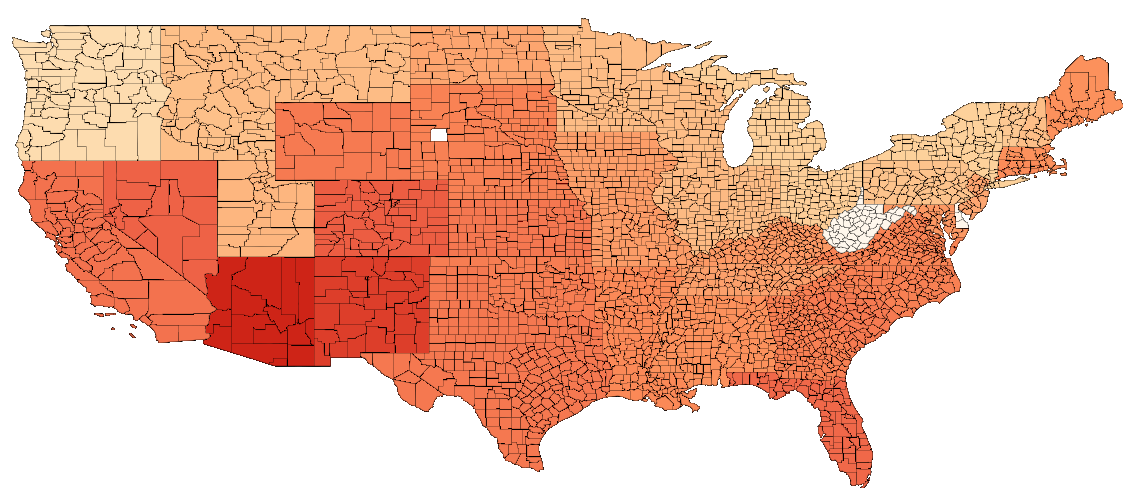

In [62]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
geo_df.plot(column='AvgDailySun', legend=False, ax=ax,cmap='OrRd',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 100);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

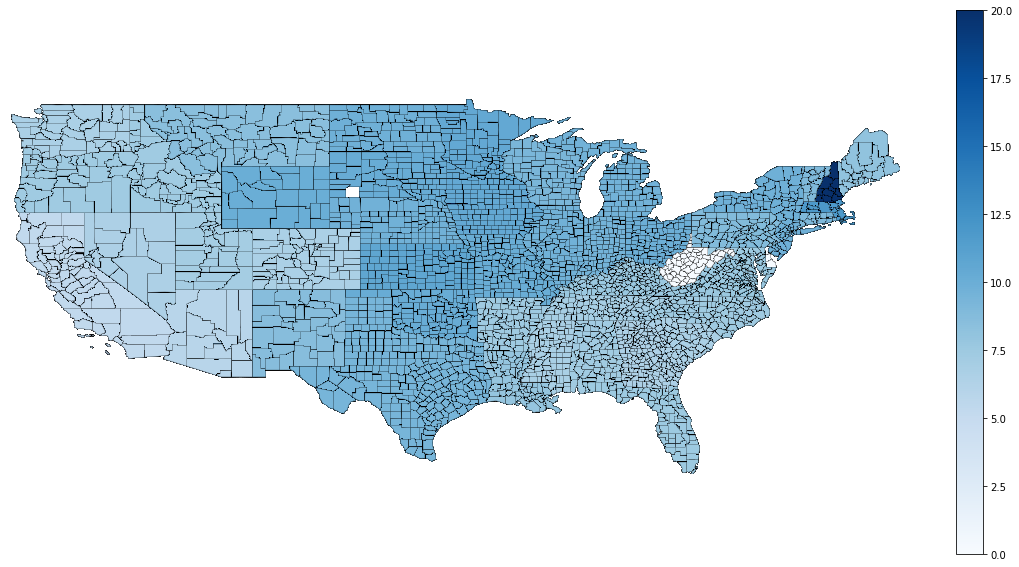

In [68]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
geo_df.plot(column='AvgWindSpeed', legend=True, ax=ax,cmap='Blues',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 20);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

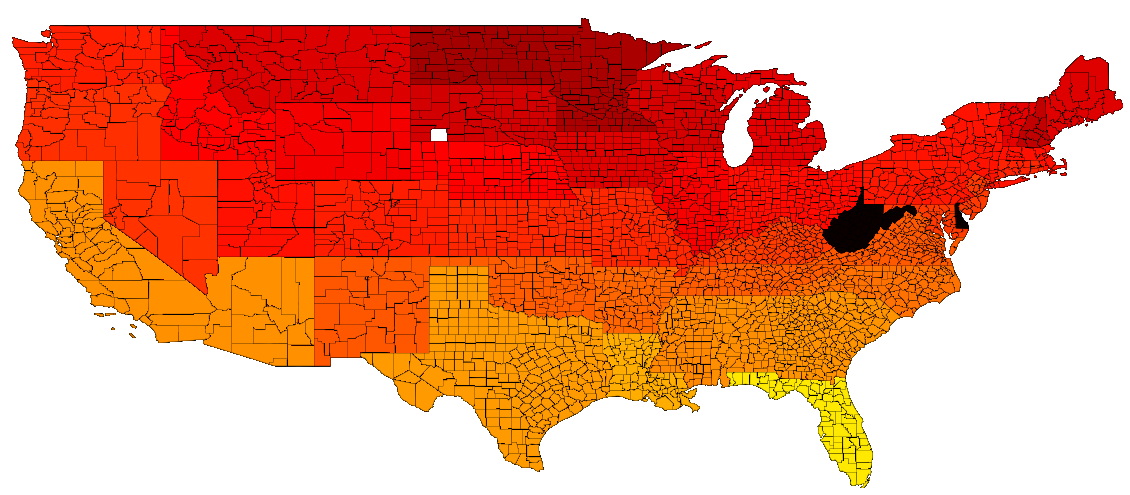

In [64]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
geo_df.plot(column='MaxTemp', legend=True, ax=ax,cmap='hot',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 100);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

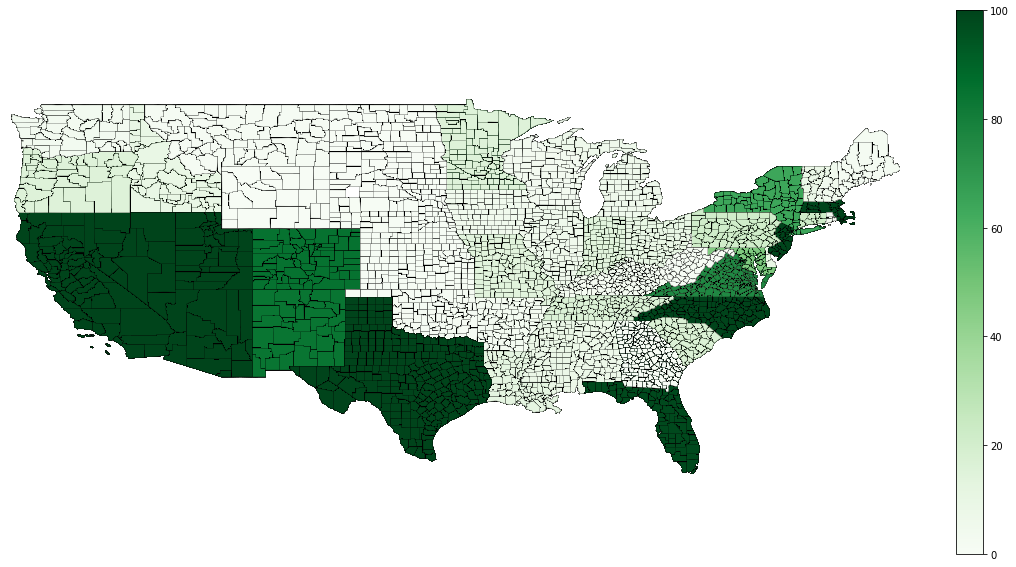

In [66]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
geo_df.plot(column='EnergyGen_all solar', legend=True, ax=ax,cmap='Greens',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 100);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

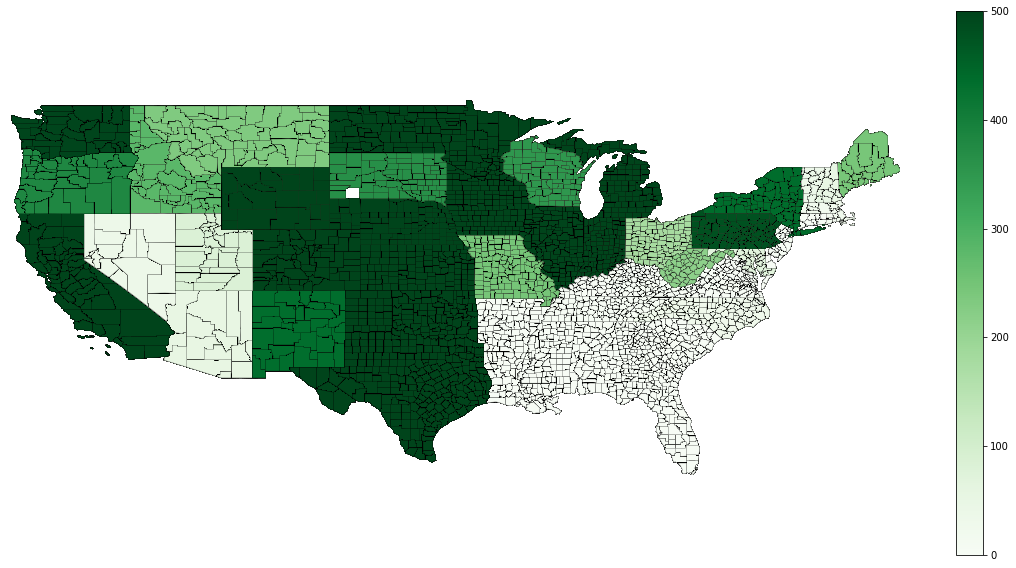

In [67]:
# Visualize high winds, high temps, high sun
fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'aspect':'equal'})
geo_df.plot(column='EnergyGen_wind', legend=True, ax=ax,cmap='Greens',edgecolor='black',linewidths=0.2,vmin = 0, vmax = 500);
ax.set_xlim(-125, -67)
ax.set_ylim(25, 50)
plt.axis('off')
plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)